In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

path = 'donnees_TD1/d04_text_400432_raw_2016_01_12.txt'
data = pd.read_csv(path, names = ["Timestamp", "Station","Lane_1_Flow", "Lane_1_Occ", "Lane_1_Speed",
                                  "Lane_2_Flow", "Lane_2_Occ", "Lane_2_Speed", 
                                  "Lane_3_Flow", "Lane_3_Occ", "Lane_3_Speed",
                                  "Lane_4_Flow", "Lane_4_Occ", "Lane_4_Speed", 
                                  "Lane_5_Flow", "Lane_5_Occ", "Lane_5_Speed",
                                  "Lane_6_Flow", "Lane_6_Occ", "Lane_6_Speed", 
                                  "Lane_7_Flow", "Lane_7_Occ", "Lane_7_Speed",
                                  "Lane_8_Flow", "Lane_8_Occ", "Lane_8_Speed"])

In [2]:
data.head()

,Timestamp,Station,Lane_1_Flow,Lane_1_Occ,Lane_1_Speed,Lane_2_Flow,Lane_2_Occ,Lane_2_Speed,Lane_3_Flow,Lane_3_Occ,...,Lane_5_Speed,Lane_6_Flow,Lane_6_Occ,Lane_6_Speed,Lane_7_Flow,Lane_7_Occ,Lane_7_Speed,Lane_8_Flow,Lane_8_Occ,Lane_8_Speed
0,01/12/2016 00:00:19,400432,3,0.0167,98,7,0.0406,94,3,0.0167,...,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/12/2016 00:00:49,400432,2,0.0106,103,7,0.0400,95,5,0.0300,...,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/12/2016 00:01:19,400432,2,0.0117,93,8,0.0456,95,6,0.0356,...,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/12/2016 00:01:49,400432,3,0.0156,105,4,0.0217,100,3,0.0150,...,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/12/2016 00:02:19,400432,1,0.0056,98,3,0.0167,98,3,0.0167,...,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
indexTemps1 = [index for index, value in enumerate(data.Timestamp) if value >= "01/12/2016 06:00:00"][0]
indexTemps2 = [index for index, value in enumerate(data.Timestamp) if value <= "01/12/2016 10:00:00"][-1]

donnees6h_10h = data[indexTemps1:indexTemps2+1]

In [4]:
indexTemps1 = [index for index, value in enumerate(data.Timestamp) if value >= "01/12/2016 20:00:00"][0]
indexTemps2 = [index for index, value in enumerate(data.Timestamp) if value <= "01/12/2016 22:00:00"][-1]

donnees20h_22h = data[indexTemps1:indexTemps2+1]

In [5]:
def calculNombreObservations(donnees, voie, nombreDePassages):
    nombreOccurences = 0
    Lane_N_Flow = "Lane_%d_Flow"%voie
    
    for i in range(len(donnees)):
        if donnees[Lane_N_Flow].iloc[i] == nombreDePassages:
            nombreOccurences += 1
    return nombreOccurences

In [6]:
# ["Nombre de véhicules passés", "Nombre d'occurences", "Nombre attendues"]                         
vecteurDonnees1 = np.array([[0.0,  0.0, 0.0]])
vecteurDonnees2 = np.array([[0.0,  0.0, 0.0]])
vecteurDonnees3 = np.array([[0.0,  0.0, 0.0]])
vecteurDonnees4 = np.array([[0.0,  0.0, 0.0]])

In [7]:
def ajoutCompteObservations(vecteurDonnees, donneesXh_Yh, voie):
    vecteurDonnees[0][1] = calculNombreObservations(donneesXh_Yh,voie,0)
    Lane_N_Flow = "Lane_%d_Flow"%voie
    
    for i in range(1, max(donneesXh_Yh[Lane_N_Flow]) + 1):
        nbObservations  = calculNombreObservations(donneesXh_Yh,voie,i)
        donneesAjoutees = np.array([[i, nbObservations, 0]])
        vecteurDonnees  = np.concatenate([vecteurDonnees, donneesAjoutees])
    
    return vecteurDonnees

vecteurDonnees1 = ajoutCompteObservations(vecteurDonnees1, donnees6h_10h, 1)
vecteurDonnees2 = ajoutCompteObservations(vecteurDonnees2, donnees6h_10h, 2)
vecteurDonnees3 = ajoutCompteObservations(vecteurDonnees3, donnees20h_22h, 1)
vecteurDonnees4 = ajoutCompteObservations(vecteurDonnees4, donnees20h_22h, 2)

In [8]:
def calculApproximatifMu(vecteurDonnees):
    n = 0
    somme = 0

    for i in range(len(vecteurDonnees)):
        n += vecteurDonnees[i][1]*i
        somme += vecteurDonnees[i][1]

    return n/somme

In [9]:
def ajoutProbabilite(vecteurDonnees, mu):
    for x in range(len(vecteurDonnees)):
        prob = float(((mu**x)*np.exp(-mu))/(np.math.factorial(x)))
        nombreTotalObservations = np.sum(vecteurDonnees, axis=0)[1]
        vecteurDonnees[x][2] = nombreTotalObservations*prob

In [10]:
def testChiCarre(vecteurDonnees):
    Chi_squared = 0

    for i in range(len(vecteurDonnees)):
        observed = vecteurDonnees[i][1]
        expected = vecteurDonnees[i][2]
        Chi_squared += ((observed-expected)**2)/expected
    
    DF = len(vecteurDonnees1) - 1 - 1
    p_value = 1 - stats.chi2.cdf(Chi_squared, DF)
    
    return p_value

In [11]:
mu = calculApproximatifMu(vecteurDonnees1)
ajoutProbabilite(vecteurDonnees1, mu)
print('%.4e'% (testChiCarre(vecteurDonnees1)))

0.0000e+00


In [12]:
mu = calculApproximatifMu(vecteurDonnees2)
ajoutProbabilite(vecteurDonnees2, mu)
print('%.4e'%testChiCarre(vecteurDonnees2))

0.0000e+00


In [13]:
mu = calculApproximatifMu(vecteurDonnees3)
ajoutProbabilite(vecteurDonnees3, mu)
print('%.4e'%testChiCarre(vecteurDonnees3))

0.0000e+00


In [14]:
mu = calculApproximatifMu(vecteurDonnees4)
ajoutProbabilite(vecteurDonnees4, mu)
print('%.4e'%testChiCarre(vecteurDonnees4))

0.0000e+00


In [15]:
# np.savetxt("Donnees_produites/vecteurDonnees1.csv", vecteurDonnees1, fmt=['%d','%d','%.4f'],  delimiter=',')
# np.savetxt("Donnees_produites/vecteurDonnees2.csv", vecteurDonnees2, fmt=['%d','%d','%.4f'],  delimiter=',')
# np.savetxt("Donnees_produites/vecteurDonnees3.csv", vecteurDonnees3, fmt=['%d','%d','%.4f'],  delimiter=',')
# np.savetxt("Donnees_produites/vecteurDonnees4.csv", vecteurDonnees4, fmt=['%d','%d','%.4f'],  delimiter=',')

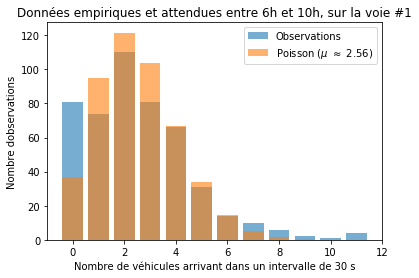

In [16]:
# Exercice 2
plt.bar(vecteurDonnees1[:,0],vecteurDonnees1[:,1], alpha=0.6, label='Observations')
plt.bar(vecteurDonnees1[:,0],vecteurDonnees1[:,2], alpha=0.6, label=r'Poisson ($\mu$ $\approx$ 2.56)')
plt.xlabel('Nombre de véhicules arrivant dans un intervalle de 30 s')
plt.ylabel('Nombre d''observations')
plt.title('Données empiriques et attendues entre 6h et 10h, sur la voie #1')
plt.legend(),
# plt.savefig('Donnees_produites/Figures/poisson_6_10_1.png', format='png')
plt.show()

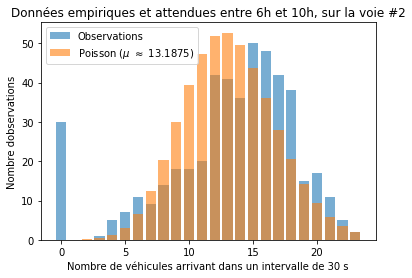

In [17]:
plt.bar(vecteurDonnees2[:,0],vecteurDonnees2[:,1], alpha=0.6, label='Observations')
plt.bar(vecteurDonnees2[:,0],vecteurDonnees2[:,2], alpha=0.6, label=r'Poisson ($\mu$ $\approx$ 13.1875)')
plt.xlabel('Nombre de véhicules arrivant dans un intervalle de 30 s')
plt.ylabel('Nombre d''observations')
plt.title('Données empiriques et attendues entre 6h et 10h, sur la voie #2')
plt.legend()
plt.savefig('Donnees_produites/Figures/poisson_6_10_2.png', format='png')
plt.show()

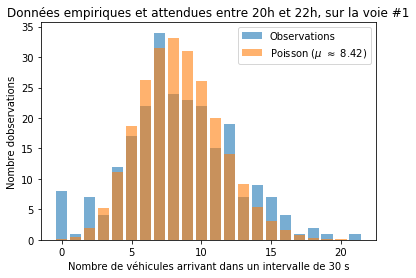

In [18]:
plt.xlabel('Nombre de véhicules arrivant dans un intervalle de 30 s')
plt.ylabel('Nombre d''observations')
plt.title('Données empiriques et attendues entre 20h et 22h, sur la voie #1')
plt.bar(vecteurDonnees3[:,0],vecteurDonnees3[:,1], alpha=0.6, label='Observations')
plt.bar(vecteurDonnees3[:,0],vecteurDonnees3[:,2], alpha=0.6, label=r'Poisson ($\mu$ $\approx$ 8.42)')
plt.legend()
# plt.savefig('Donnees_produites/Figures/poisson_20_22_1.png', format='png')
plt.show()

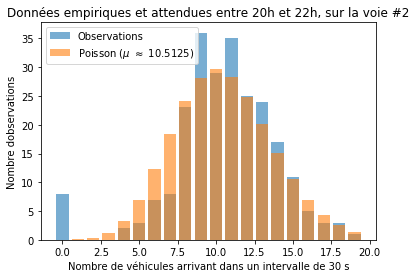

In [19]:
plt.xlabel('Nombre de véhicules arrivant dans un intervalle de 30 s')
plt.ylabel('Nombre d''observations')
plt.title('Données empiriques et attendues entre 20h et 22h, sur la voie #2')
plt.bar(vecteurDonnees4[:,0],vecteurDonnees4[:,1], alpha=0.6, label='Observations')
plt.bar(vecteurDonnees4[:,0],vecteurDonnees4[:,2], alpha=0.6, label=r'Poisson ($\mu$ $\approx$ 10.5125)')
plt.legend(loc = 'upper left')
# plt.savefig('Donnees_produites/Figures/poisson_20_22_2.png', format='png')
plt.show()